In [101]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [102]:
import pandas as pd
import numpy as np
from numpy import newaxis
import math
import os
import json
import datetime as dt
import time

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### versions

In [105]:
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('tensorflow:', tf.__version__)
print('keras:', keras.__version__)

numpy: 1.18.5
pandas: 1.1.4
tensorflow: 2.3.1
keras: 2.4.0


# Time Series Prediction Using LSTM Neural Network
https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks

### sine wave example
- load data and investigate
- create training data
- create model
- train model
- create test data
- predict one point at a time
- predict from only 1 test data window
- predict multiple sequences   
   
### stock market example
- load data and investigate   
   
### stock market close: predict using only close data
### stock market close: predict using close and volume data

# load code from `py` files

### `utils.py`

In [106]:
# %load downloaded_py_files/utils.py
#import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))

### `data_processor.py`

In [107]:
# %load downloaded_py_files/data_processor.py
#import math
#import numpy as np
#import pandas as pd

class DataLoader():
    """A class for loading and transforming data for the lstm model"""

    def __init__(self, filename, split, cols):
        dataframe = pd.read_csv(filename)
        i_split = int(len(dataframe) * split)
        self.data_train = dataframe.get(cols).values[:i_split]
        self.data_test  = dataframe.get(cols).values[i_split:]
        self.len_train  = len(self.data_train)
        self.len_test   = len(self.data_test)
        self.len_train_windows = None

    def get_test_data(self, seq_len, normalise):
        '''
        Create x, y test data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise reduce size of the training split.
        '''
        data_windows = []
        for i in range(self.len_test - seq_len):
            data_windows.append(self.data_test[i:i+seq_len])

        data_windows = np.array(data_windows).astype(float)
        data_windows = self.normalise_windows(data_windows, single_window=False) if normalise else data_windows

        x = data_windows[:, :-1]
        y = data_windows[:, -1, [0]]
        return x,y

    def get_train_data(self, seq_len, normalise):
        '''
        Create x, y train data windows
        Warning: batch method, not generative, make sure you have enough memory to
        load data, otherwise use generate_training_window() method.
        '''
        data_x = []
        data_y = []
        for i in range(self.len_train - seq_len):
            x, y = self._next_window(i, seq_len, normalise)
            data_x.append(x)
            data_y.append(y)
        return np.array(data_x), np.array(data_y)

    def generate_train_batch(self, seq_len, batch_size, normalise):
        '''Yield a generator of training data from filename on given list of cols split for train/test'''
        i = 0
        while i < (self.len_train - seq_len):
            x_batch = []
            y_batch = []
            for b in range(batch_size):
                if i >= (self.len_train - seq_len):
                    # stop-condition for a smaller final batch if data doesn't divide evenly
                    yield np.array(x_batch), np.array(y_batch)
                    i = 0
                x, y = self._next_window(i, seq_len, normalise)
                x_batch.append(x)
                y_batch.append(y)
                i += 1
            yield np.array(x_batch), np.array(y_batch)

    def _next_window(self, i, seq_len, normalise):
        '''Generates the next data window from the given index location i'''
        window = self.data_train[i:i+seq_len]
        window = self.normalise_windows(window, single_window=True)[0] if normalise else window
        x = window[:-1]
        y = window[-1, [0]]
        return x, y

    def normalise_windows(self, window_data, single_window=False):
        '''Normalise window with a base value of zero'''
        normalised_data = []
        window_data = [window_data] if single_window else window_data
        for window in window_data:
            normalised_window = []
            for col_i in range(window.shape[1]):
                normalised_col = [((float(p) / float(window[0, col_i])) - 1) for p in window[:, col_i]]
                normalised_window.append(normalised_col)
            normalised_window = np.array(normalised_window).T # reshape and transpose array back into original multidimensional format
            normalised_data.append(normalised_window)
        return np.array(normalised_data)

### `model.py`

In [108]:
# %load downloaded_py_files/model.py
#import os
#import math
#import numpy as np
#import datetime as dt
#from numpy import newaxis
#from core.utils import Timer
#from keras.layers import Dense, Activation, Dropout, LSTM
#from keras.models import Sequential, load_model
#from keras.callbacks import EarlyStopping, ModelCheckpoint

class Model():
	"""A class for an building and inferencing an lstm model"""

	def __init__(self):
		self.model = Sequential()

	def load_model(self, filepath):
		print('[Model] Loading model from file %s' % filepath)
		self.model = load_model(filepath)

	def build_model(self, configs):
		timer = Timer()
		timer.start()

		for layer in configs['model']['layers']:
			neurons = layer['neurons'] if 'neurons' in layer else None
			dropout_rate = layer['rate'] if 'rate' in layer else None
			activation = layer['activation'] if 'activation' in layer else None
			return_seq = layer['return_seq'] if 'return_seq' in layer else None
			input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
			input_dim = layer['input_dim'] if 'input_dim' in layer else None

			if layer['type'] == 'dense':
				self.model.add(Dense(neurons, activation=activation))
			if layer['type'] == 'lstm':
				self.model.add(LSTM(neurons, input_shape=(input_timesteps, input_dim), return_sequences=return_seq))
			if layer['type'] == 'dropout':
				self.model.add(Dropout(dropout_rate))

		self.model.compile(loss=configs['model']['loss'], optimizer=configs['model']['optimizer'])

		print('[Model] Model Compiled')
		timer.stop()

	def train(self, x, y, epochs, batch_size, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size' % (epochs, batch_size))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			EarlyStopping(monitor='val_loss', patience=2),
			ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
		]
		self.model.fit(
			x,
			y,
			epochs=epochs,
			batch_size=batch_size,
			callbacks=callbacks
		)
		self.model.save(save_fname)

		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def train_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
		timer = Timer()
		timer.start()
		print('[Model] Training Started')
		print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))
		
		save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
		callbacks = [
			ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
		]
		self.model.fit_generator(
			data_gen,
			steps_per_epoch=steps_per_epoch,
			epochs=epochs,
			callbacks=callbacks,
			workers=1
		)
		
		print('[Model] Training Completed. Model saved as %s' % save_fname)
		timer.stop()

	def predict_point_by_point(self, data):
		#Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
		print('[Model] Predicting Point-by-Point...')
		predicted = self.model.predict(data)
		predicted = np.reshape(predicted, (predicted.size,))
		return predicted

	def predict_sequences_multiple(self, data, window_size, prediction_len):
		#Predict sequence of 50 steps before shifting prediction run forward by 50 steps
		print('[Model] Predicting Sequences Multiple...')
		prediction_seqs = []
		for i in range(int(len(data)/prediction_len)):
			curr_frame = data[i*prediction_len]
			predicted = []
			for j in range(prediction_len):
				predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
				curr_frame = curr_frame[1:]
				curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
			prediction_seqs.append(predicted)
		return prediction_seqs

	def predict_sequence_full(self, data, window_size):
		#Shift the window by 1 new prediction each time, re-run predictions on new window
		print('[Model] Predicting Sequences Full...')
		curr_frame = data[0]
		predicted = []
		for i in range(len(data)):
			predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
			curr_frame = curr_frame[1:]
			curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
		return predicted


### `run.py`

In [109]:
# %load downloaded_py_files/run.py
#__author__ = "Jakob Aungiers"
#__copyright__ = "Jakob Aungiers 2018"
#__version__ = "2.0.0"
#__license__ = "MIT"

#import os
#import json
#import time
#import math
#import matplotlib.pyplot as plt
#from core.data_processor import DataLoader
#from core.model import Model


def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
    #plt.show()
    return fig, ax

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
	# Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend(bbox_to_anchor=(1.1,1), loc='upper right')
    #plt.show()
    return fig, ax

In [110]:
def do_modeling(config_file_name):
    configs = json.load(open(config_file_name, 'r'))
    if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
    )

    '''
	# in-memory training
	model.train(
		x,
		y,
		epochs = configs['training']['epochs'],
		batch_size = configs['training']['batch_size'],
		save_dir = configs['model']['save_dir']
	)
	'''
    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
        ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
    )


    x_test, y_test = data.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
        )
    
    return model, x_test, y_test


    #predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    # predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    # predictions = model.predict_point_by_point(x_test)

    #plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    # plot_results(predictions, y_test)


# sine wave example

### load data directly and investigate

In [111]:
sin_data = pd.read_csv('data\sinewave.csv')

In [112]:
sin_data.shape
sin_data.head()
sin_data.columns
sin_data.info()

(5001, 1)

,sinewave
0,0.841471
1,0.873736
2,0.902554
3,0.927809
4,0.949402


Index(['sinewave'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sinewave  5001 non-null   float64
dtypes: float64(1)
memory usage: 39.2 KB


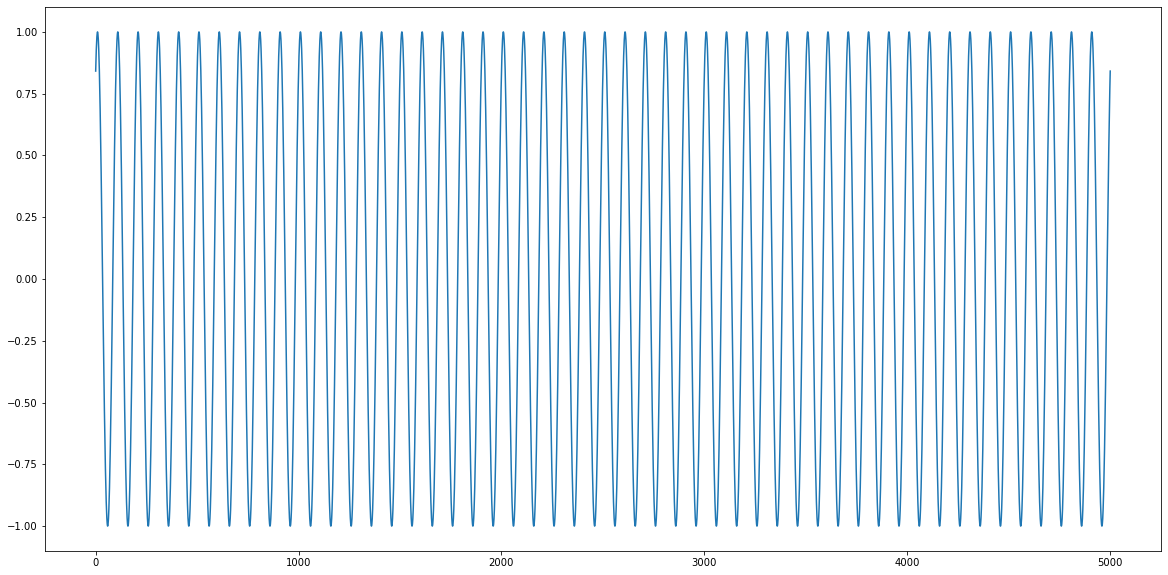

In [113]:
_ = plt.figure(figsize=(20,10))
_ = plt.plot(sin_data)

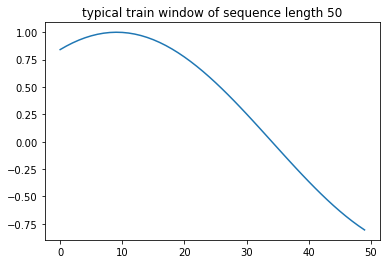

In [114]:
#_ = plt.figure(figsize=(20,10))
_ = plt.plot(sin_data[:50])
_ = plt.title('typical train window of sequence length 50')

### load data using utility methods

In [115]:
configs = json.load(open('data\config_sinewave.json', 'r'))
configs

{'data': {'filename': 'sinewave.csv',
  'columns': ['sinewave'],
  'sequence_length': 50,
  'train_test_split': 0.8,
  'normalise': False},
 'training': {'epochs': 2, 'batch_size': 32},
 'model': {'loss': 'mse',
  'optimizer': 'adam',
  'save_dir': 'saved_models',
  'layers': [{'type': 'lstm',
    'neurons': 50,
    'input_timesteps': 49,
    'input_dim': 1,
    'return_seq': True},
   {'type': 'dropout', 'rate': 0.05},
   {'type': 'lstm', 'neurons': 100, 'return_seq': False},
   {'type': 'dropout', 'rate': 0.05},
   {'type': 'dense', 'neurons': 1, 'activation': 'linear'}]}}

In [116]:
#if not os.path.exists(configs['model']['save_dir']): os.makedirs(configs['model']['save_dir'])

In [117]:
data_sin = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
        )
    
data_sin.data_train.shape
data_sin.data_train[:10]
data_sin.data_test.shape
data_sin.data_test[:10]

(4000, 1)

array([[0.84147098],
       [0.8737364 ],
       [0.90255357],
       [0.92780878],
       [0.94940235],
       [0.96724906],
       [0.98127848],
       [0.99143524],
       [0.99767927],
       [0.9999859 ]])

(1001, 1)

array([[0.84147098],
       [0.8737364 ],
       [0.90255357],
       [0.92780878],
       [0.94940235],
       [0.96724906],
       [0.98127848],
       [0.99143524],
       [0.99767927],
       [0.9999859 ]])

### create training data
`x.shape`: (N, W, F)   
N = number training sequences   
W = sequence length   
F = number features in each sequence

In [118]:
x, y = data_sin.get_train_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
        )
x.shape
y.shape

(3950, 49, 1)

(3950, 1)

### create model

In [119]:
model_sin = Model()
model_sin.build_model(configs)

[Model] Model Compiled
Time taken: 0:00:00.884405


### train model

In [120]:
# out-of memory generative training
steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
model_sin.train_generator(
            data_gen=data.generate_train_batch(
            seq_len=configs['data']['sequence_length'],
            batch_size=configs['training']['batch_size'],
            normalise=configs['data']['normalise']
            ),
        epochs=configs['training']['epochs'],
        batch_size=configs['training']['batch_size'],
        steps_per_epoch=steps_per_epoch,
        save_dir=configs['model']['save_dir']
        )

[Model] Training Started
[Model] 2 epochs, 32 batch size, 124 batches per epoch
Epoch 1/2
124/124 [==============================] - 8s 66ms/step - loss: 0.0333
Epoch 2/2
124/124 [==============================] - 8s 65ms/step - loss: 0.0011
[Model] Training Completed. Model saved as saved_models\30112020-143656-e2.h5
Time taken: 0:00:21.078963


### create test data

In [121]:
x_test, y_test = data_sin.get_test_data(
        seq_len=configs['data']['sequence_length'],
        normalise=configs['data']['normalise']
        )
x_test.shape
y_test.shape

(951, 49, 1)

(951, 1)

### predict one point at a time
For each sliding window in test set, predict the 1 next point.

In [122]:
pred_1_sin = model_sin.predict_point_by_point(x_test)

[Model] Predicting Point-by-Point...


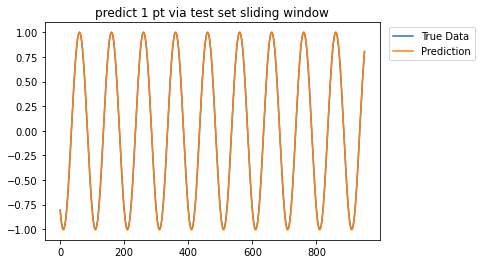

In [123]:
fig, ax = plot_results(pred_1_sin, y_test)
_ = ax.set_title('predict 1 pt via test set sliding window')

### predict from only 1 test data window
- start with 1st window in test data
- predict 1 point
- shift window to include that point, predict 1 more again
- repeat
- after window_size predictions, all subsequent predictions based entirely on previous predictions   
   
##### result: predictions farther into future have reduced accuracy for period and amplitude

In [124]:
pred_full_sin = model_sin.predict_sequence_full(x_test, configs['data']['sequence_length'])

[Model] Predicting Sequences Full...


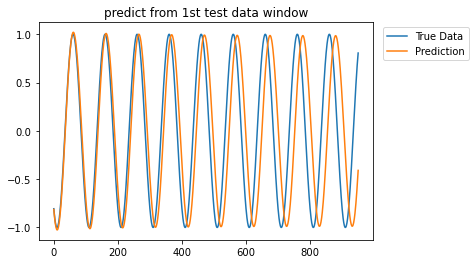

In [125]:
fig, ax = plot_results(pred_full_sin, y_test)
_ = ax.set_title('predict from 1st test data window')

### predict multiple sequences
- start with 1st window in test data
- predict point-by-point each time sliding window to include new prediction
- when window no longer includes any original data, start with another full original window and repeat   
   
##### result: very good matches

In [126]:
pred_multi_sin = model_sin.predict_sequences_multiple(x_test, configs['data']['sequence_length'],
                                               configs['data']['sequence_length'])

[Model] Predicting Sequences Multiple...


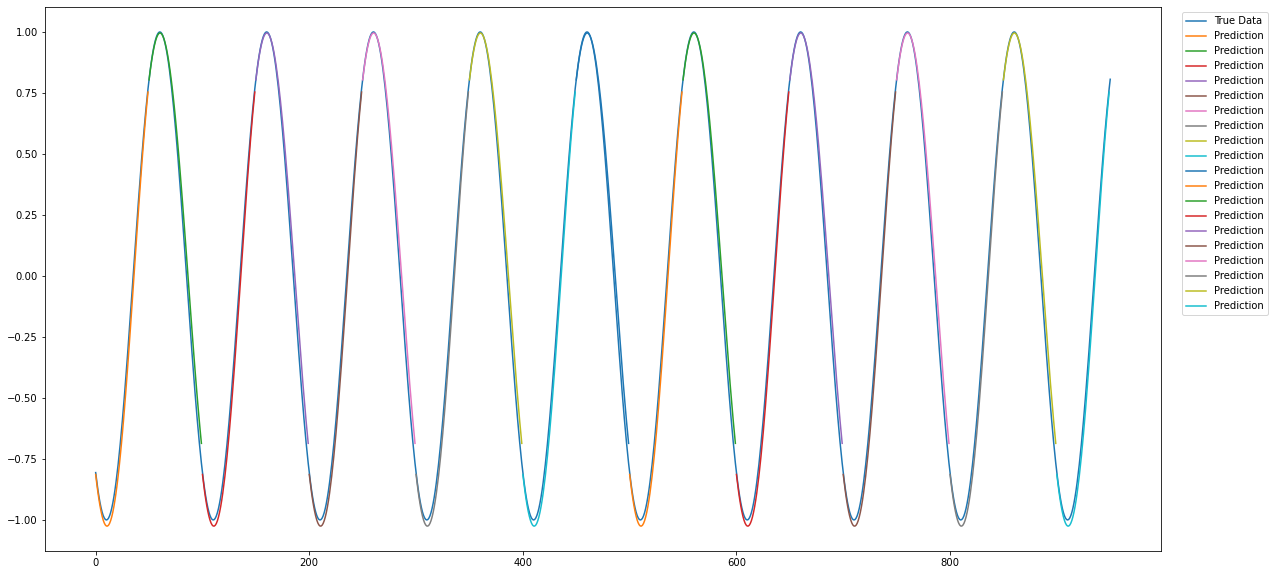

In [127]:
fig, ax = plot_results_multiple(pred_multi_sin, y_test, configs['data']['sequence_length'])

# stock market example

### load data directly and investigate

In [128]:
sp500_data = pd.read_csv('data\sp500.csv')

In [129]:
sp500_data.shape
sp500_data.head()
sp500_data.columns
sp500_data.info()

(4697, 6)

,Date,Open,High,Low,Close,Volume
0,03-01-00,1469.250000,1478.000000,1438.359985,1455.219971,931800000
1,04-01-00,1455.219971,1455.219971,1397.430054,1399.420044,1009000000
2,05-01-00,1399.420044,1413.270020,1377.680054,1402.109985,1085500000
3,06-01-00,1402.109985,1411.900024,1392.099976,1403.449951,1092300000
4,07-01-00,1403.449951,1441.469971,1400.729980,1441.469971,1225200000


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4697 entries, 0 to 4696
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    4697 non-null   object 
 1   Open    4697 non-null   float64
 2   High    4697 non-null   float64
 3   Low     4697 non-null   float64
 4   Close   4697 non-null   float64
 5   Volume  4697 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 220.3+ KB


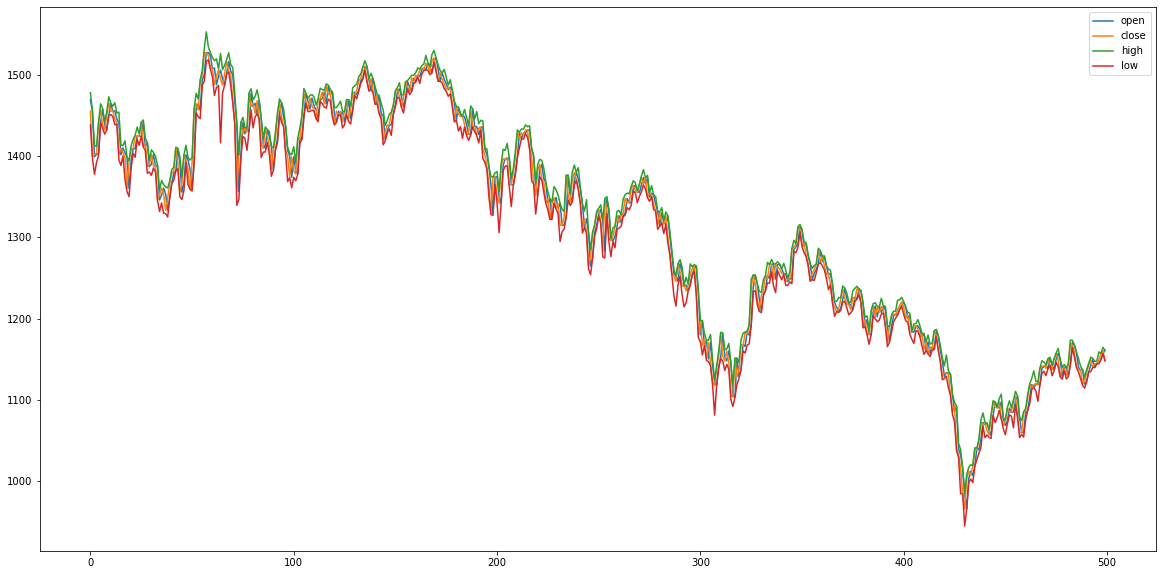

In [130]:
data_to_plot = sp500_data[:500]
_ = plt.figure(figsize=(20,10))
_ = plt.plot(data_to_plot['Open'], label='open')
_ = plt.plot(data_to_plot['Close'], label='close')
_ = plt.plot(data_to_plot['High'], label='high')
_ = plt.plot(data_to_plot['Low'], label='low')
_ = plt.legend()

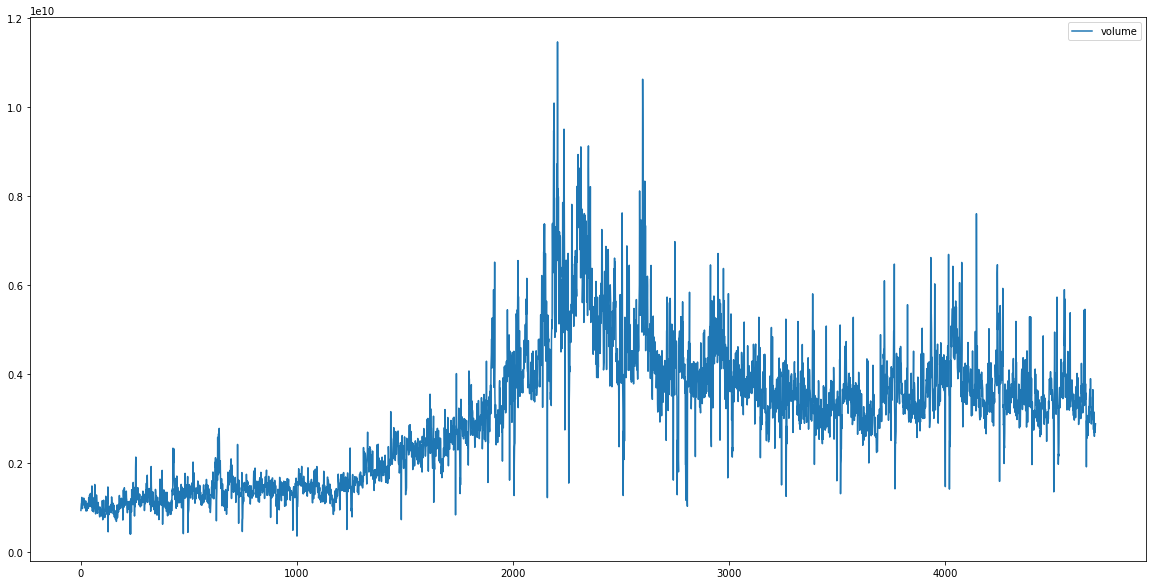

In [131]:
_ = plt.figure(figsize=(20,10))
_ = plt.plot(sp500_data['Volume'], label='volume')
_ = plt.legend()

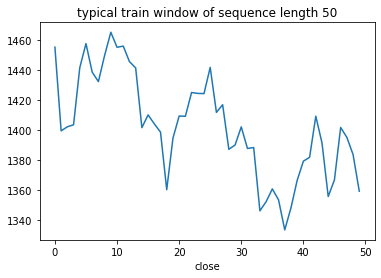

In [132]:
_ = plt.plot(sp500_data[:50]['Close'])
_ = plt.title('typical train window of sequence length 50')
_ = plt.xlabel('close')

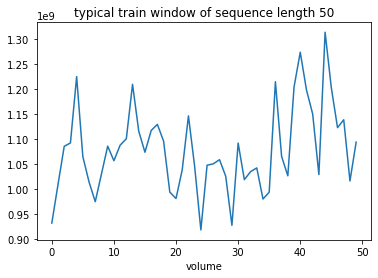

In [133]:
_ = plt.plot(sp500_data[:50]['Volume'])
_ = plt.title('typical train window of sequence length 50')
_ = plt.xlabel('volume')

# stock market close: predict using only close data
### results
- point-by-point prediction with true history window gives fairly good match
- full prediction from only 1 true history window does poorly
- multi-window prediction gives good trend result for most windows

In [134]:
the_model_close_1, x_test_1, y_test_1 = do_modeling('data\config_sp500_close.json')

[Model] Model Compiled
Time taken: 0:00:01.087206
[Model] Training Started
[Model] 1 epochs, 32 batch size, 124 batches per epoch
124/124 [==============================] - 14s 116ms/step - loss: 9.4989e-04
[Model] Training Completed. Model saved as saved_models\30112020-143903-e1.h5
Time taken: 0:00:21.756243


In [135]:
configs_1 = json.load(open('data\config_sp500_close.json', 'r'))

In [136]:
predict_multiseq_1 = the_model_close_1.predict_sequences_multiple(x_test_1, configs_1['data']['sequence_length'], configs_1['data']['sequence_length'])
predict_fullseq_1  = the_model_close_1.predict_sequence_full(x_test_1, configs_1['data']['sequence_length'])
predict_point_1    = the_model_close_1.predict_point_by_point(x_test_1)

[Model] Predicting Sequences Multiple...
[Model] Predicting Sequences Full...
[Model] Predicting Point-by-Point...


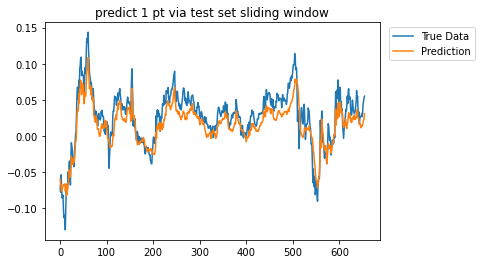

In [137]:
fig, ax = plot_results(predict_point_1, y_test_1)
_ = ax.set_title('predict 1 pt via test set sliding window')

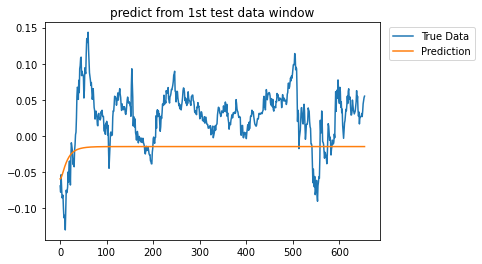

In [138]:
fig, ax = plot_results(predict_fullseq_1, y_test_1)
_ = ax.set_title('predict from 1st test data window')

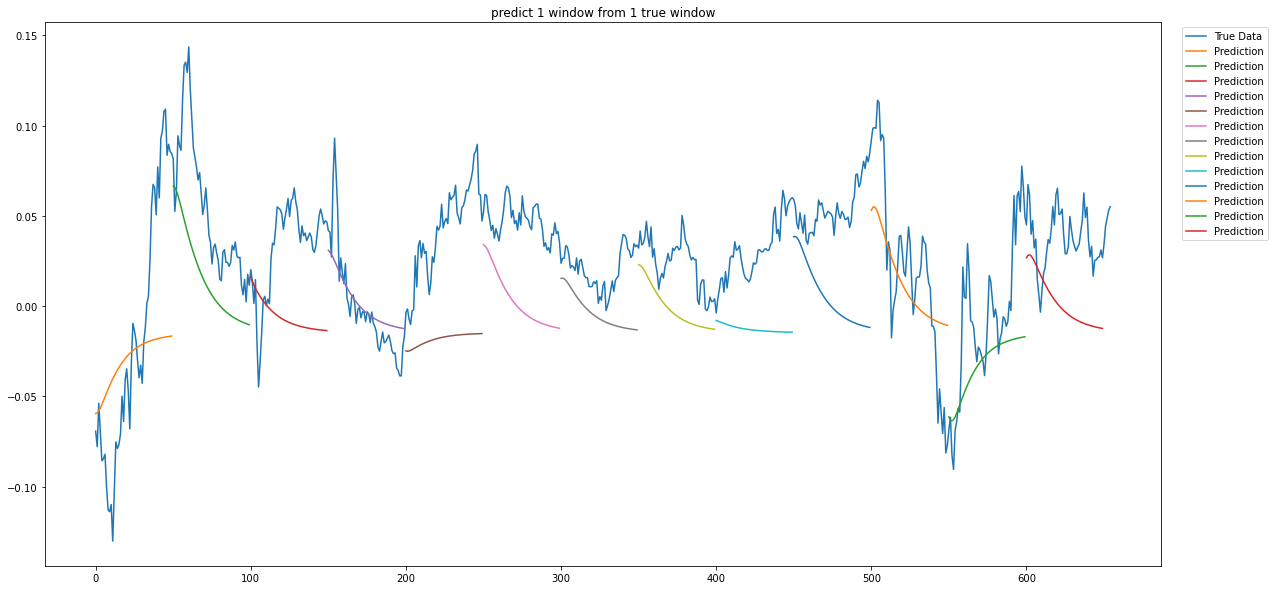

In [139]:
fig, ax = plot_results_multiple(predict_multiseq_1, y_test_1, configs_1['data']['sequence_length'])
_ = ax.set_title('predict 1 window from 1 true window')

# stock market close: predict using close and volume data
### results
- point-by-point prediction with true history window gives fairly good match
- full prediction from only 1 true history window does poorly
- multi-window prediction gives good trend result for most windows

In [140]:
the_model_close_2, x_test_2, y_test_2 = do_modeling('data\config_sp500.json')

[Model] Model Compiled
Time taken: 0:00:01.381699
[Model] Training Started
[Model] 2 epochs, 32 batch size, 124 batches per epoch
Epoch 1/2
124/124 [==============================] - 15s 120ms/step - loss: 0.0020
Epoch 2/2
124/124 [==============================] - 14s 111ms/step - loss: 7.5525e-04
[Model] Training Completed. Model saved as saved_models\30112020-144045-e2.h5
Time taken: 0:00:36.090429


In [141]:
configs_2 = json.load(open('data\config_sp500.json', 'r'))

In [142]:
predict_multiseq_2 = the_model_close_2.predict_sequences_multiple(x_test_2, configs_2['data']['sequence_length'], configs_2['data']['sequence_length'])
predict_fullseq_2  = the_model_close_2.predict_sequence_full(x_test_2, configs_2['data']['sequence_length'])
predict_point_2    = the_model_close_2.predict_point_by_point(x_test_2)

[Model] Predicting Sequences Multiple...
[Model] Predicting Sequences Full...
[Model] Predicting Point-by-Point...


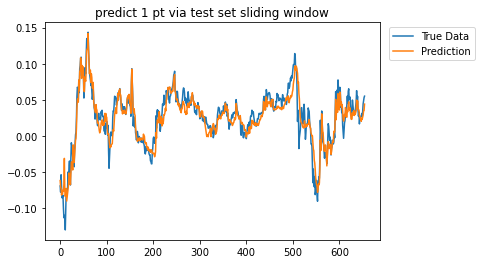

In [143]:
fig, ax = plot_results(predict_point_2, y_test_2)
_ = ax.set_title('predict 1 pt via test set sliding window')

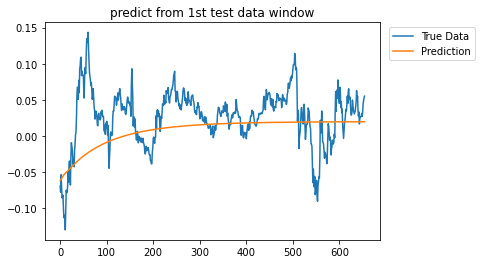

In [144]:
fig, ax = plot_results(predict_fullseq_2, y_test_2)
_ = ax.set_title('predict from 1st test data window')

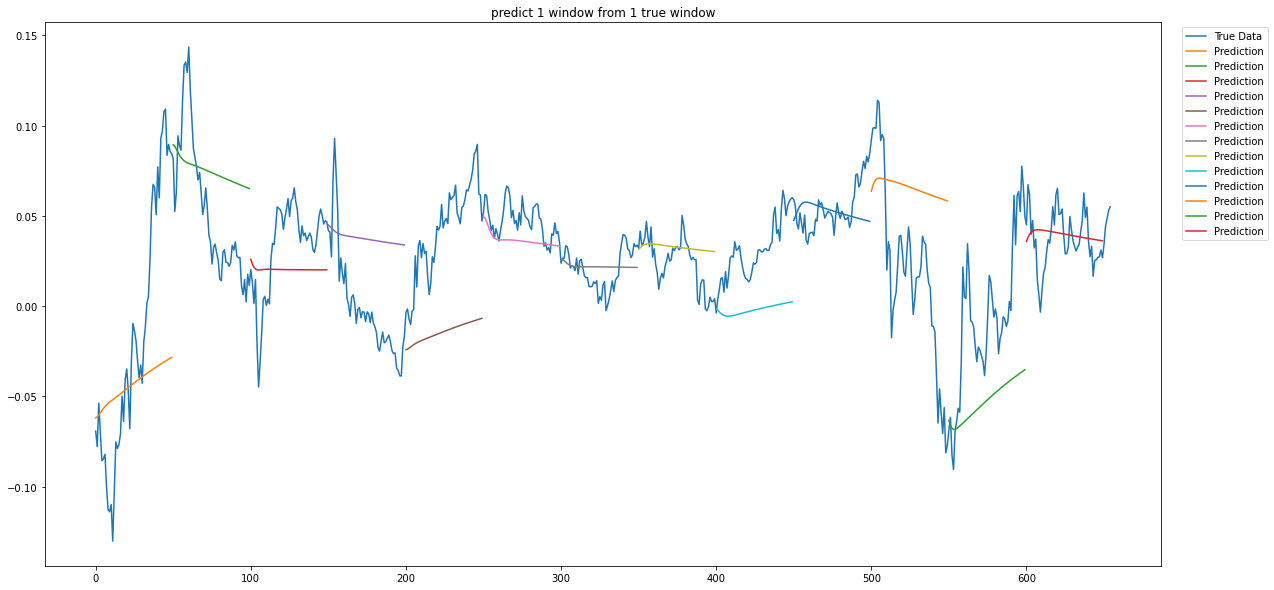

In [145]:
fig, ax = plot_results_multiple(predict_multiseq_2, y_test_2, configs_2['data']['sequence_length'])
_ = ax.set_title('predict 1 window from 1 true window')